## Dataset exploration

This is probably going to be a minimal EDA notebook looking at tool calling datasets that exists in market right now

In [1]:
#!pip install datasets

In [96]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import networkx as nx

### Hermes-Function-Calling v1

- Apache 2.0
- Single-Turn: 2k
- Func_calling: 2k
- Glaive: 5k
- Json mode agent: 1.3k
- Json mode single: 1.24k

https://huggingface.co/datasets/NousResearch/hermes-function-calling-v1

In [26]:
d = load_dataset("NousResearch/hermes-function-calling-v1")

In [27]:
d['train']

Dataset({
    features: ['id', 'conversations', 'category', 'subcategory', 'task'],
    num_rows: 1893
})

In [28]:
d['train'][123].keys()

dict_keys(['id', 'conversations', 'category', 'subcategory', 'task'])

In [29]:
d['train'][123]

{'id': '936b90da-dbeb-4864-a6e6-28899965265d',
 'conversations': [{'from': 'system',
   'value': "You are a function calling AI model. You are provided with function signatures within <tools> </tools> XML tags. You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.\n<tools>\n[{'type': 'function', 'function': {'name': 'scale_up_cluster', 'description': 'Scales up the number of compute nodes in an HPC cluster.', 'parameters': {'type': 'object', 'properties': {'cluster_name': {'type': 'string', 'description': 'The name of the HPC cluster to scale up.'}, 'node_type': {'type': 'string', 'description': 'The type of compute node to add to the cluster.'}, 'additional_nodes': {'type': 'integer', 'description': 'The number of additional compute nodes to add to the cluster.'}}, 'required': ['cluster_name', 'node_type', 'additional_nodes']}}}, {'type': 'function', 'function': {'name': 'scale_down_cluster', 'description': '

In [30]:
d['train'][400]

{'id': 'f9b15d86-fb69-4f05-a65e-18f2f7b5369d',
 'conversations': [{'from': 'system',
   'value': "You are a function calling AI model. You are provided with function signatures within <tools> </tools> XML tags. You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.\n<tools>\n[{'type': 'function', 'function': {'name': 'min_max_normalize', 'description': 'Apply Min-Max normalization to scale features in the dataset to a specified range.', 'parameters': {'type': 'object', 'properties': {'data': {'type': 'string', 'description': 'The path to the dataset file.'}, 'feature_range': {'type': 'object', 'properties': {'min': {'type': 'number', 'description': 'The minimum value of the target range for normalization.'}, 'max': {'type': 'number', 'description': 'The maximum value of the target range for normalization.'}}, 'required': ['min', 'max']}}, 'required': ['data', 'feature_range']}}}, {'type': 'function', 'function'

In [31]:
set(d['train']['category'])

{'AI Model Integration',
 'API Call',
 'Accounting & Finance',
 'Algorithmic Trading',
 'Annotation',
 'Blockchain Integration',
 'Business Intelligence',
 'CRM',
 'Cloud Platforms',
 'Code Interpreters',
 'Communication Services Software',
 'Compliance',
 'Consumer Discretionary Software',
 'Consumer Staples Software',
 'Data Centers and High Performance Computing',
 'Data Privacy',
 'Data Processing',
 'Database Management',
 'Decentralized Apps (DApps)',
 'Desktop Applications',
 'DevOps',
 'Document Ranking',
 'E-commerce Platforms',
 'Energy Software',
 'Financial Services Apps',
 'Financial Software',
 'Git Operations',
 'HR',
 'Healthcare Software',
 'Identity and Access Management (IAM)',
 'Industrial Software',
 'Information Extraction',
 'Information Retrieval (RAG)',
 'Information Technology Software',
 'IoT Platforms',
 'IoT and Home Automation',
 'Low-Code Enterprise Platforms',
 'Marketing',
 'Materials Software',
 'Mobile Applications',
 'Model APIs',
 'Named Entity Reco

In [35]:
def extract_functions_from_system(system_message):
    tools_match = re.search(r'<tools>(.*?)</tools>', system_message, re.DOTALL)
    if tools_match:
        tools_str = tools_match.group(1).strip()
        # Convert Python string representation to valid JSON
        tools_str = tools_str.replace("'", '"')
        try:
            return json.loads(tools_str)
        except json.JSONDecodeError as e:
            print(f"Error parsing tools string: {tools_str[:100]}...")
            return []
    return []

def extract_tool_calls(gpt_message):
    tool_calls = []
    matches = re.finditer(r'<tool_call>(.*?)</tool_call>', gpt_message, re.DOTALL)
    for match in matches:
        try:
            tool_call_str = match.group(1).strip()
            # Clean up the string and ensure it's valid JSON
            tool_call_str = tool_call_str.replace("'", '"')
            tool_call = json.loads(tool_call_str)
            tool_calls.append(tool_call)
        except json.JSONDecodeError as e:
            print(f"Error parsing tool call: {tool_call_str[:100]}...")
            continue
    return tool_calls

#### Some EDA

The analsysis is on a part of the dataset but still gets us a good overview

In [36]:
records = []
for split in d:  # Assuming dataset is loaded as 'd'
    for item in tqdm(d[split]):
        record = {
            'id': item['id'],
            'category': item['category'],
            'subcategory': item['subcategory'],
            'task': item['task'],
            'split': split
        }
        
        conversations = item['conversations']
        system_msg = next(msg['value'] for msg in conversations if msg['from'] == 'system')
        human_msg = next(msg['value'] for msg in conversations if msg['from'] == 'human')
        gpt_msg = next(msg['value'] for msg in conversations if msg['from'] == 'gpt')
        
        available_functions = extract_functions_from_system(system_msg)
        tool_calls = extract_tool_calls(gpt_msg)
        
        record.update({
            'num_available_functions': len(available_functions),
            'num_tool_calls': len(tool_calls),
            'human_msg_length': len(human_msg),
            'available_functions': [f['function']['name'] for f in available_functions],
            'called_functions': [call['name'] for call in tool_calls],
            'conversation_turns': len(conversations),
            'human_msg': human_msg,
            'gpt_msg': gpt_msg
        })
        records.append(record)

df = pd.DataFrame(records)

 63%|█████████████████████████████████▉                    | 1190/1893 [00:00<00:00, 5958.41it/s]

Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tool call: {"arguments": {"appliance_id": "WM-002", "auto_off": True}, "name": "set_washing_machine_auto_off"}...
Error parsing tools string: ...
Error parsing tool call: {"arguments": {"confirmation_required": True}, "name": "lock_all_smart_doors"}...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tools string: ...
Error parsing tool call: {"arguments": {"device_id": "smart_plug_123", "on_time": "19:00", "off_time": "23:00", "repeat_daily...
Error parsing tools string: ...
Error parsing tool call: {"arguments": {"function_type": "periodic", "fourier_components": 5, "auxiliary_qubits": 2, "contro

100%|██████████████████████████████████████████████████████| 1893/1893 [00:00<00:00, 5791.39it/s]

Error parsing tools string: ...
Error parsing tool call: \n{"arguments": {"queries": ["How do the concepts of Big O complexity and binary search trees relate...
Error parsing tools string: ...
Error parsing tool call: \n{"arguments": {"queries": ["What tips or strategies would you suggest for converting a matrix into...
Error parsing tools string: ...
Error parsing tool call: \n{"arguments": {"queries": ["How are the concepts of vector addition and scalar multiplication conn...
Error parsing tools string: ...
Error parsing tool call: \n{"arguments": {"queries": ["Can you summarize the process of determining the production schedule f...
Error parsing tools string: ...
Error parsing tool call: \n{"arguments": {"queries": ["In your opinion, are there any potential benefits to experiencing writ...
Error parsing tools string: ...
Error parsing tool call: \n{"arguments": {"queries": ["What is the main goal of the theorems presented in this section?", "Ho...
Error parsing tools string: ...
Er

In [37]:
df

,id,category,subcategory,task,split,num_available_functions,num_tool_calls,human_msg_length,available_functions,called_functions,conversation_turns,human_msg,gpt_msg
0,85f6c398-69c7-4df2-aed1-29d614a93a26,IoT and Home Automation,Security Camera Management,View and Manage Security Camera Feeds,train,0,3,1670,[],"[get_camera_live_feed, record_camera_feed, get...",3,I've recently installed a new security system ...,<tool_call>\n{'arguments': {'camera_id': 'fron...
1,89ef3c87-66bd-46ee-9297-15398fd9a235,IoT and Home Automation,Smart Home Setup,Set Up a Smart Home System,train,0,2,916,[],"[initialize_smart_home_system, create_device_g...",3,I've recently equipped my home with various sm...,<tool_call>\n{'arguments': {'device_list': ['P...
2,14657d01-d6d1-46df-8eb1-7267ba820683,IoT and Home Automation,Thermostat Control,Adjust Smart Thermostat Settings,train,0,1,757,[],[set_thermostat_schedule],3,I recently installed a smart thermostat model ...,<tool_call>\n{'arguments': {'thermostat_id': '...
3,c483f963-8a29-4ff0-a684-89be0d0f2843,IoT and Home Automation,Voice Commands for Home Tasks,Perform Home Tasks Using Voice Commands,train,0,3,1058,[],"[activate_voice_command, set_thermostat, activ...",3,I just arrived home and I'm carrying several b...,<tool_call>\n{'arguments': {'command': 'Activa...
4,81ad724a-bb74-420f-8221-91557b7e5930,IoT and Home Automation,Lighting Control,Control Smart Lights in a Home,train,0,2,556,[],"[set_smart_light_color, sync_lights_with_autom...",3,I am preparing my living room for a cozy movie...,<tool_call>\n{'arguments': {'room': 'living ro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888,90b96a9f-85c3-459f-95bd-7c58557a4b02,Information Extraction,Json Schema,Structured json schema extaction with function...,train,0,0,9349,[],[],3,Can you help me extract queries from the follo...,"<tool_call>\n{""arguments"": {""queries"": ['hat i..."
1889,f698e236-d733-4a24-af41-64831a7139ac,Information Extraction,Json Schema,Structured json schema extaction with function...,train,0,0,13462,[],[],3,Can you help me extract queries from the follo...,"<tool_call>\n{""arguments"": {""queries"": ['How d..."
1890,0eed5d10-8d6e-4aaf-9b49-ad299ee02c5d,Information Extraction,Json Schema,Structured json schema extaction with function...,train,0,0,11526,[],[],3,Can you help me extract queries from the follo...,"<tool_call>\n{""arguments"": {""queries"": ['How d..."
1891,cf305996-bae4-46f2-b725-d540b1d3ea5c,Information Extraction,Json Schema,Structured json schema extaction with function...,train,0,0,10049,[],[],3,Can you help me extract queries from the follo...,"<tool_call>\n{""arguments"": {""queries"": ['Can y..."


Dataset Overview:
Total samples: 1893
Number of unique categories: 63
Number of unique subcategories: 865

Average tool calls per conversation: 1.03
Average available functions: 0.00


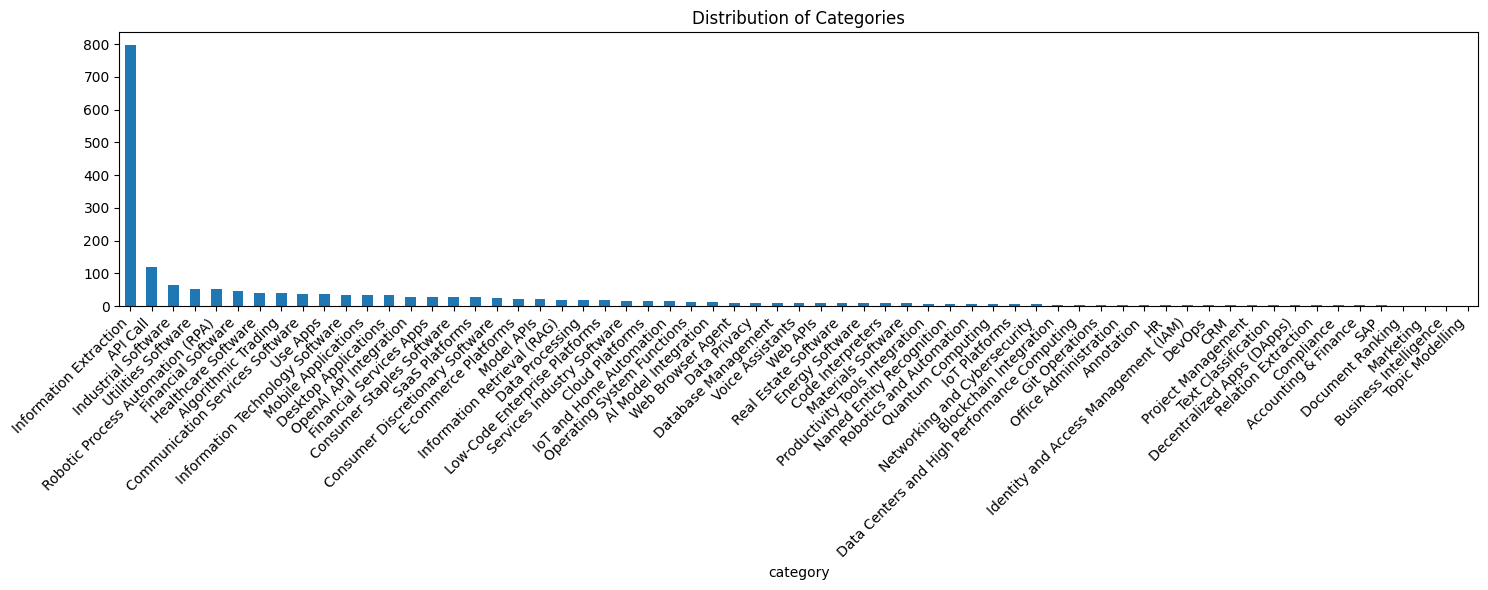

In [38]:
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Number of unique categories: {df['category'].nunique()}")
print(f"Number of unique subcategories: {df['subcategory'].nunique()}")
print(f"\nAverage tool calls per conversation: {df['num_tool_calls'].mean():.2f}")
print(f"Average available functions: {df['num_available_functions'].mean():.2f}")

# Category Analysis
plt.figure(figsize=(15, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [39]:
subcategory_counts = df['subcategory'].value_counts().head(10)
print("\nTop 10 Subcategories:")
print(subcategory_counts)



Top 10 Subcategories:
subcategory
Json Schema          793
 JSON Schema          26
Android               21
JSON Schema           14
iPhone                13
Data Retrieval        11
Microsoft 365          7
Hugging Face           7
Data Modification      7
Salesforce             5
Name: count, dtype: int64


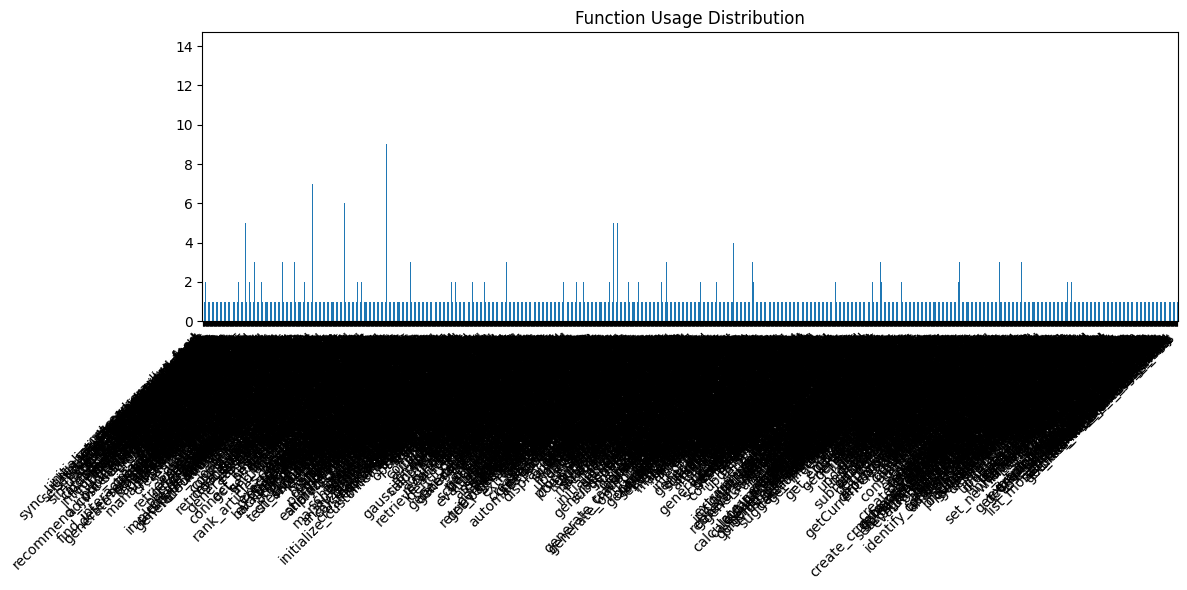

In [40]:
all_called_functions = [f for funcs in df['called_functions'] for f in funcs]
function_counts = Counter(all_called_functions)

plt.figure(figsize=(12, 6))
pd.Series(function_counts).plot(kind='bar')
plt.title('Function Usage Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

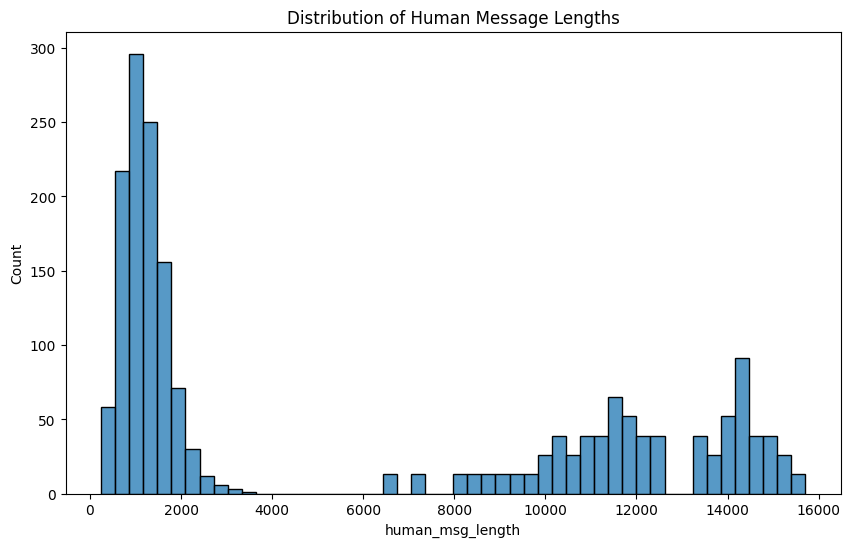

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='human_msg_length', bins=50)
plt.title('Distribution of Human Message Lengths')
plt.show()

In [42]:
function_pairs = []
for functions in df['called_functions']:
    if len(functions) > 1:
        pairs = [(f1, f2) for i, f1 in enumerate(functions) 
                for f2 in functions[i+1:]]
        function_pairs.extend(pairs)

In [43]:
cooccurrence = Counter(function_pairs)
print("\nTop Function Co-occurrences:")
for (f1, f2), count in sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{f1} & {f2}: {count}")


Top Function Co-occurrences:
get_social_media_statistics & get_social_media_statistics: 36
registerDeviceWithIoTCore & configureDeviceMQTT: 25
get_market_prices & get_account_balance: 18
get_account_balance & get_account_balance: 15
registerDeviceWithIoTCore & registerDeviceWithIoTCore: 10


In [44]:
function_by_category = df.groupby('category')['called_functions'].apply(
    lambda x: Counter([f for funcs in x for f in funcs])
).reset_index()


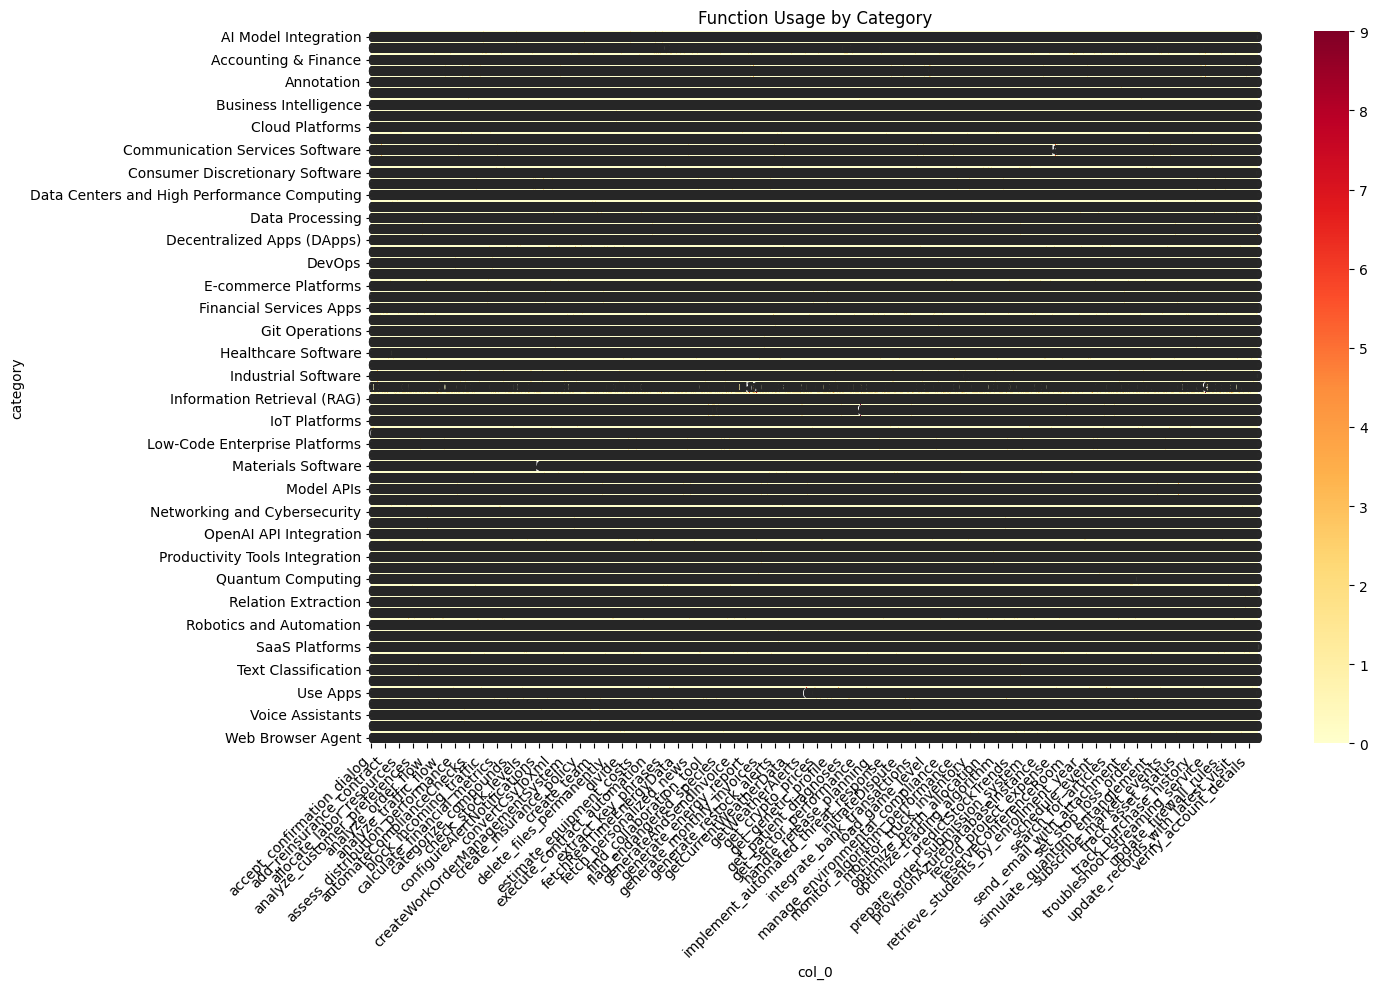

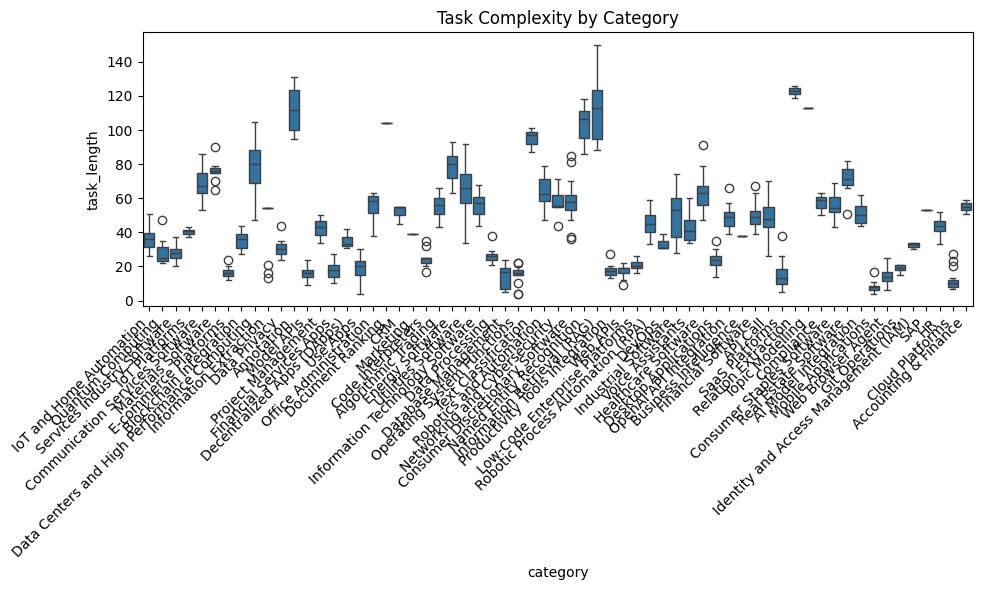

In [45]:
function_matrix = pd.crosstab(df['category'], 
                            pd.Series([f for funcs in df['called_functions'] for f in funcs]))

plt.figure(figsize=(15, 10))
sns.heatmap(function_matrix, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Function Usage by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Task Complexity Analysis
df['task_length'] = df['task'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='task_length', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Task Complexity by Category')
plt.tight_layout()
plt.show()

In [46]:
print("\nSample Conversation Analysis:")
sample_idx = np.random.randint(len(df))
sample = df.iloc[sample_idx]
print(f"\nCategory: {sample['category']}")
print(f"Task: {sample['task']}")
print(f"Available Functions: {sample['available_functions']}")
print(f"Called Functions: {sample['called_functions']}")


Sample Conversation Analysis:

Category: Services Industry Software
Task: Generate client invoices.
Available Functions: []
Called Functions: []


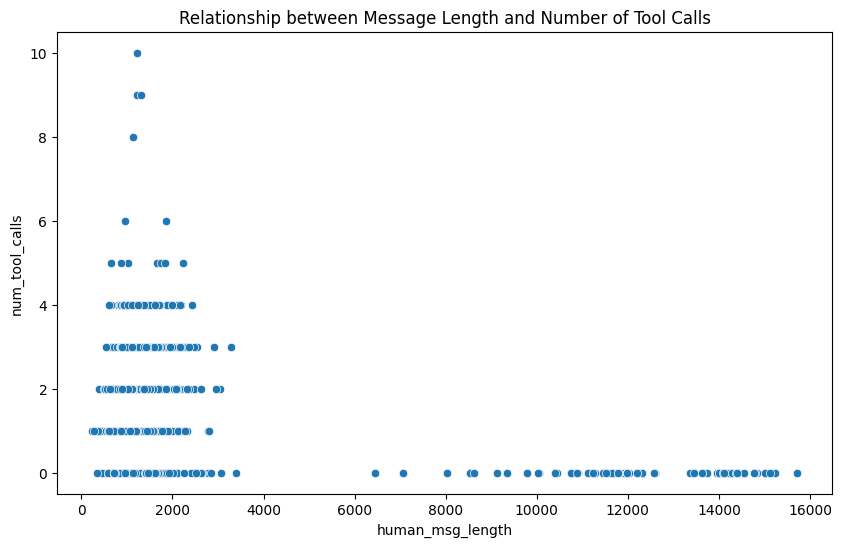

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='human_msg_length', y='num_tool_calls')
plt.title('Relationship between Message Length and Number of Tool Calls')
plt.show()

In [50]:
numerical_cols = ['num_tool_calls', 'num_available_functions', 
                 'human_msg_length', 'conversation_turns', 'task_length']
correlation_matrix = df[numerical_cols].corr()

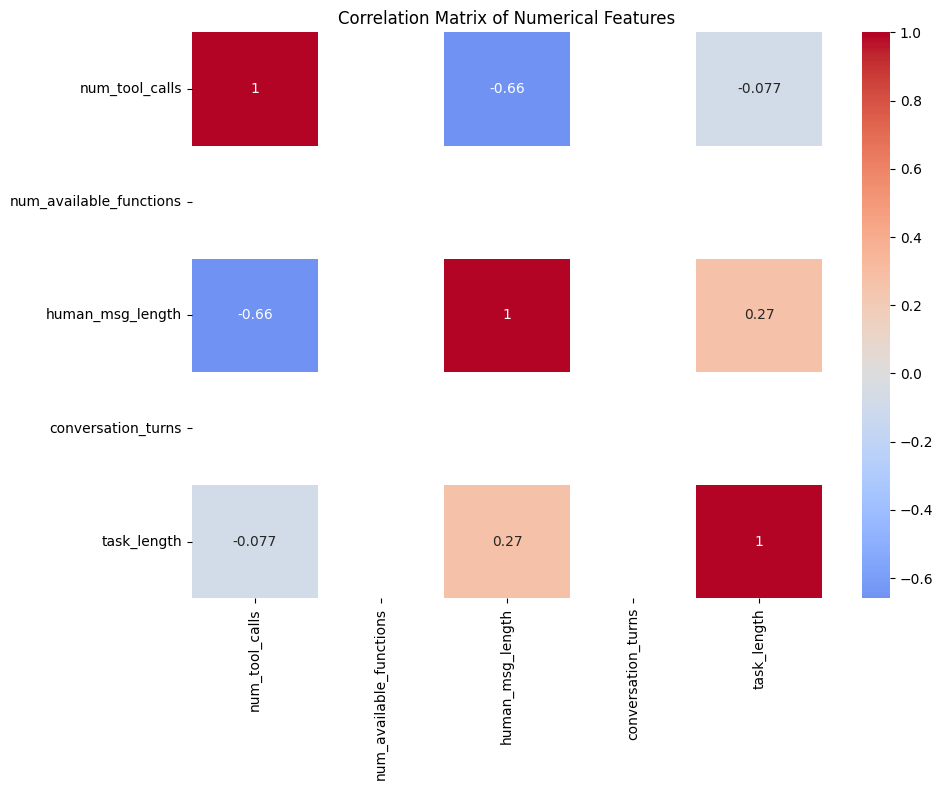

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [52]:
summary_stats = df.groupby('category').agg({
    'num_tool_calls': ['mean', 'std'],
    'human_msg_length': ['mean', 'std'],
    'conversation_turns': ['mean', 'std']
}).round(2)

print("\nSummary Statistics by Category:")
print(summary_stats)


Summary Statistics by Category:
                     num_tool_calls       human_msg_length          \
                               mean   std             mean     std   
category                                                             
AI Model Integration           2.08  2.15          1175.25  264.97   
API Call                       1.58  0.99           917.49  334.36   
Accounting & Finance           1.50  0.71           983.00  130.11   
Algorithmic Trading            1.87  1.22          1493.77  416.28   
Annotation                     1.25  0.50          1192.00  654.47   
...                             ...   ...              ...     ...   
Use Apps                       1.43  1.50           793.14  231.93   
Utilities Software             2.02  1.16          1622.67  420.90   
Voice Assistants               1.50  1.08           935.90  266.69   
Web APIs                       1.33  1.12           999.67  212.40   
Web Browser Agent              1.27  0.90          1016.2

### Pandora Tool Calling

- Based on glaive-ai function calling
- BSD-3
- 100k examples
- 
https://huggingface.co/datasets/danilopeixoto/pandora-tool-calling

In [53]:
d = load_dataset("danilopeixoto/pandora-tool-calling")

In [54]:
d['train'][21313]

{'messages': [{'role': 'system',
   'content': 'You are a helpful assistant with access to functions and tools. Use them if required.',
   'tools': None,
   'tool_calls': None,
   'name': None},
  {'role': 'system',
   'content': None,
   'tools': '[{"name": "generate_random_quote", "description": "Generate a random inspirational quote", "parameters": {}}, {"name": "calculate_loan_payment", "description": "Calculate the monthly payment for a loan", "parameters": {"type": "object", "properties": {"loan_amount": {"type": "number", "description": "The total loan amount"}, "interest_rate": {"type": "number", "description": "The annual interest rate on the loan"}, "loan_term": {"type": "integer", "description": "The duration of the loan in months"}}, "required": ["loan_amount", "interest_rate", "loan_term"]}}]',
   'tool_calls': None,
   'name': None},
  {'role': 'user',
   'content': "I'm feeling a bit down today. Can you share something inspiring?",
   'tools': None,
   'tool_calls': None

In [55]:
def safe_json_loads(json_str):
    if not json_str:
        return None
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        return None

In [56]:
def extract_tools_and_calls(messages):
    tools = []
    tool_calls = []
    conversation_flow = []
    
    for msg in messages:
        # Track conversation flow
        conversation_flow.append({
            'role': msg['role'],
            'has_content': bool(msg['content']),
            'has_tools': bool(msg['tools']),
            'has_tool_calls': bool(msg['tool_calls'])
        })
        
        # Extract tools
        if msg['tools']:
            parsed_tools = safe_json_loads(msg['tools'])
            if parsed_tools:
                tools.extend(parsed_tools)
        
        # Extract tool calls
        if msg['tool_calls']:
            parsed_calls = safe_json_loads(msg['tool_calls'])
            if parsed_calls:
                tool_calls.extend(parsed_calls)
    
    return {
        'available_tools': tools,
        'tool_calls': tool_calls,
        'conversation_flow': conversation_flow,
        'num_messages': len(messages),
        'num_tools': len(tools),
        'num_tool_calls': len(tool_calls)
    }

In [57]:
records = []
for item in tqdm(d['train']):
    messages = item['messages']
    
    user_messages = [msg for msg in messages if msg['role'] == 'user']
    assistant_messages = [msg for msg in messages if msg['role'] == 'assistant']
    tool_messages = [msg for msg in messages if msg['role'] == 'tool']
    
    conv_analysis = extract_tools_and_calls(messages)
    
    record = {
        'num_messages': len(messages),
        'num_user_messages': len(user_messages),
        'num_assistant_messages': len(assistant_messages),
        'num_tool_messages': len(tool_messages),
        
        # Tool information
        'num_available_tools': conv_analysis['num_tools'],
        'num_tool_calls': conv_analysis['num_tool_calls'],
        'available_tools': [tool['name'] for tool in conv_analysis['available_tools']],
        'tool_calls': [call['name'] for call in conv_analysis['tool_calls']],
        
        # Message content
        'user_query': user_messages[0]['content'] if user_messages else None,
        'user_query_length': len(user_messages[0]['content']) if user_messages and user_messages[0]['content'] else 0,
        
        # Store full conversation flow for pattern analysis
        'conversation_flow': conv_analysis['conversation_flow']
    }
    
    records.append(record)

df = pd.DataFrame(records)

100%|██████████████████████████████████████████████████| 101114/101114 [00:14<00:00, 6898.85it/s]


In [58]:
print("\nDataset Overview:")
print(f"Total conversations: {len(df)}")
print(f"Average messages per conversation: {df['num_messages'].mean():.2f}")
print(f"Average tool calls per conversation: {df['num_tool_calls'].mean():.2f}")


Dataset Overview:
Total conversations: 101114
Average messages per conversation: 7.46
Average tool calls per conversation: 0.74


In [59]:
all_tools = [tool for tools in df['available_tools'] for tool in tools]
all_calls = [call for calls in df['tool_calls'] for call in calls]

In [60]:
print("\nTool Usage:")
print("Available Tools Distribution:")
tool_dist = Counter(all_tools)
for tool, count in tool_dist.most_common():
    print(f"{tool}: {count}")


Tool Usage:
Available Tools Distribution:
calculate_bmi: 4157
convert_currency: 4055
calculate_distance: 4010
calculate_age: 3980
calculate_tip: 3819
calculate_discount: 3529
get_stock_price: 2618
generate_qr_code: 2497
generate_password: 2396
search_books: 2274
calculate_loan_payment: 2206
generate_random_number: 2130
search_recipes: 2127
get_movie_details: 1999
send_email: 1950
calculate_area: 1865
generate_random_password: 1754
create_todo: 1385
create_calendar_event: 1376
search_movies: 1250
calculate_mortgage_payment: 1046
translate_text: 958
analyze_sentiment: 954
search_recipe: 942
get_news: 841
get_definition: 797
calculate_tax: 777
create_note: 737
search_restaurants: 691
generate_invoice: 674
get_news_headlines: 668
search_movie: 597
play_music: 561
convert_temperature: 550
get_random_joke: 540
calculate_gpa: 479
create_invoice: 478
calculate_shipping_cost: 474
generate_random_quote: 471
calculate_average: 449
get_random_fact: 444
calculate_interest: 418
calculate_discounted

In [61]:
print("\nTool Calls Distribution:")
call_dist = Counter(all_calls)
for call, count in call_dist.most_common():
    print(f"{call}: {count}")


Tool Calls Distribution:
calculate_distance: 4591
convert_currency: 4224
get_stock_price: 3408
calculate_discount: 2960
calculate_bmi: 2943
calculate_tip: 2809
calculate_age: 2729
generate_random_number: 2690
calculate_area: 2599
get_movie_details: 2288
search_books: 2200
search_recipes: 1873
generate_qr_code: 1774
generate_password: 1628
calculate_loan_payment: 1502
search_movies: 1360
send_email: 1334
generate_random_password: 1210
translate_text: 1175
analyze_sentiment: 1149
get_definition: 1057
get_news: 1002
create_calendar_event: 957
create_todo: 955
get_news_headlines: 790
calculate_tax: 760
search_recipe: 745
calculate_mortgage_payment: 742
search_restaurants: 639
search_movie: 605
play_music: 579
convert_temperature: 573
generate_random_quote: 498
create_note: 496
calculate_shipping_cost: 491
generate_invoice: 463
get_random_fact: 462
create_invoice: 375
search_news: 371
get_random_joke: 370
search_jobs: 365
calculate_discounted_price: 343
generate_barcode: 332
calculate_inte

Text(0, 0.5, 'Frequency')

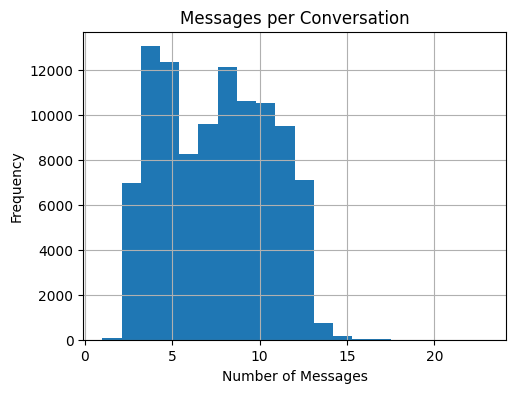

In [62]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df['num_messages'].hist(bins=20)
plt.title('Messages per Conversation')
plt.xlabel('Number of Messages')
plt.ylabel('Frequency')

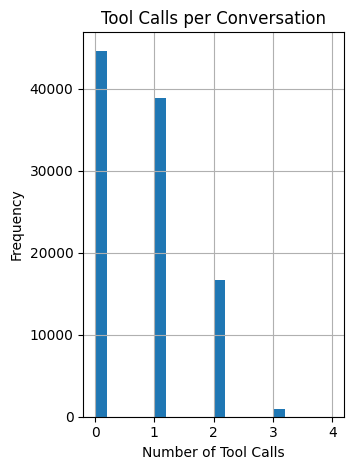

In [63]:
plt.subplot(1, 2, 2)
df['num_tool_calls'].hist(bins=20)
plt.title('Tool Calls per Conversation')
plt.xlabel('Number of Tool Calls')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [64]:
def analyze_conversation_patterns(flows):
    patterns = []
    for flow in flows:
        pattern = []
        for msg in flow:
            if msg['has_tool_calls']:
                pattern.append('TOOL_CALL')
            elif msg['role'] == 'tool':
                pattern.append('TOOL_RESPONSE')
            else:
                pattern.append(msg['role'].upper())
        patterns.append('->'.join(pattern))
    return Counter(patterns)

In [65]:
conversation_patterns = analyze_conversation_patterns(df['conversation_flow'])
print("\nMost Common Conversation Patterns:")
for pattern, count in conversation_patterns.most_common(5):
    print(f"{pattern}: {count}")


Most Common Conversation Patterns:
SYSTEM->USER->ASSISTANT: 6819
SYSTEM->SYSTEM->USER->ASSISTANT: 6738
SYSTEM->USER->ASSISTANT->USER->ASSISTANT: 6353
USER->ASSISTANT->USER->ASSISTANT: 6151
SYSTEM->USER->TOOL_CALL->TOOL_RESPONSE->ASSISTANT: 5959


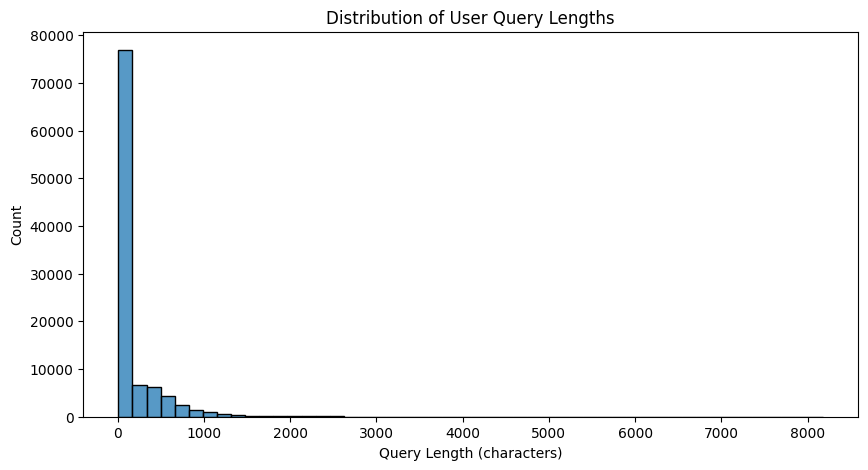

In [66]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='user_query_length', bins=50)
plt.title('Distribution of User Query Lengths')
plt.xlabel('Query Length (characters)')
plt.show()

In [67]:
tool_sequences = df[df['num_tool_calls'] > 0]['tool_calls'].value_counts()
print("\nMost Common Tool Call Sequences:")
print(tool_sequences.head())


Most Common Tool Call Sequences:
tool_calls
[calculate_bmi]                             2701
[calculate_age]                             2665
[calculate_tip]                             2363
[calculate_distance, calculate_distance]    1882
[calculate_discount]                        1837
Name: count, dtype: int64


In [68]:
print("\nSample Conversation Analysis:")
sample_idx = np.random.randint(len(df))
sample = df.iloc[sample_idx]
print(f"\nUser Query: {sample['user_query']}")
print(f"Number of Messages: {sample['num_messages']}")
print(f"Available Tools: {sample['available_tools']}")
print(f"Tool Calls Made: {sample['tool_calls']}")


Sample Conversation Analysis:

User Query: Hi, can you tell me the current stock price of Apple?
Number of Messages: 11
Available Tools: ['get_stock_price']
Tool Calls Made: ['get_stock_price', 'get_stock_price']


In [69]:
def has_error_message(conv_flow):
    """Check if conversation has error patterns"""
    tool_responses = [msg for msg in conv_flow if msg['role'] == 'tool']
    return any('error' in str(msg.get('content', '')).lower() for msg in tool_responses)

df['has_errors'] = df['conversation_flow'].apply(has_error_message)
print("\nTool Call Success Analysis:")
print(f"Success Rate: {(1 - df['has_errors'].mean()) * 100:.2f}%")


Tool Call Success Analysis:
Success Rate: 100.00%


### Reflection-v1 Glaive ai

- Apache 2.0
- 60k examples
- https://huggingface.co/datasets/glaiveai/reflection-v1

In [70]:
d = load_dataset("glaiveai/glaive-function-calling-v2")

In [71]:
d['train'][1455]

{'system': 'SYSTEM: You are a helpful assistant, with no access to external functions.\n\n',
 'chat': 'USER: How can I write a C# program that calculates the difference between two given dates in years?\nHere\'s a starter code:\nDateTime givenDate = new DateTime(2015, 8, 12);\nDateTime currentDate = DateTime.Today;\nTimeSpan difference = currentDate - givenDate;\nint years = (int)(difference.TotalDays / 365.25);\nConsole.WriteLine("The difference between the given date and today\'s date is: " + years + " years.");\nYou can replace the given date with any date of your choice. How can this code be optimized for better performance?\n\nASSISTANT: The code you provided is already quite efficient, but there are a few optimizations you can make:\n1. Instead of dividing by 365.25 to get the number of years, you can use the TotalDays property of the TimeSpan object and divide by the average number of days in a year (365.2425). This will give you a more accurate result.\n2. You can use the TryPa

### Glaive-Function-calling-v2

- Apache 2.0
- 113k rows
- https://huggingface.co/datasets/glaiveai/glaive-function-calling-v2

In [97]:
d = load_dataset("glaiveai/glaive-function-calling-v2")

In [98]:
d['train'][12312]

{'system': 'SYSTEM: You are a helpful assistant with access to the following functions. Use them if required -\n{\n    "name": "generate_invoice",\n    "description": "Generate an invoice for a given product",\n    "parameters": {\n        "type": "object",\n        "properties": {\n            "product_name": {\n                "type": "string",\n                "description": "The name of the product"\n            },\n            "quantity": {\n                "type": "integer",\n                "description": "The quantity of the product"\n            },\n            "price": {\n                "type": "number",\n                "description": "The price of the product"\n            },\n            "discount_percentage": {\n                "type": "integer",\n                "minimum": 0,\n                "maximum": 100,\n                "description": "The discount percentage"\n            }\n        },\n        "required": [\n            "product_name",\n            "quantity",\n 

In [99]:
def parse_system_functions(system_text):
    try:
        # Find the JSON object in the system message
        json_match = re.search(r'\{.*\}', system_text, re.DOTALL)
        if json_match:
            return json.loads(json_match.group())
        return None
    except json.JSONDecodeError:
        return None

In [100]:
def parse_chat_content(chat_text):
    messages = []
    parts = [p.strip() for p in chat_text.split('\n\n\n') if p.strip()]
    
    for part in parts:
        if part.startswith('USER:'):
            messages.append({
                'role': 'user',
                'content': part[5:].strip()
            })
        elif part.startswith('ASSISTANT:'):
            content = part[10:].strip()
            function_call = None
            function_match = re.search(r'<functioncall> (.*?) <\|endoftext\|>', content)
            if function_match:
                try:
                    function_call = json.loads(function_match.group(1))
                    # Parse the arguments if they're in string form
                    if isinstance(function_call.get('arguments'), str):
                        function_call['arguments'] = json.loads(function_call['arguments'])
                except json.JSONDecodeError:
                    pass
            
            messages.append({
                'role': 'assistant',
                'content': content,
                'function_call': function_call
            })
        elif part.startswith('FUNCTION RESPONSE:'):
            try:
                response = json.loads(part[17:].strip())
                messages.append({
                    'role': 'function',
                    'content': response
                })
            except json.JSONDecodeError:
                messages.append({
                    'role': 'function',
                    'content': part[17:].strip()
                })
    
    return messages

In [101]:
def get_function_params(func_def):
    if not func_def or not isinstance(func_def, dict):
        return [], []
    
    params = func_def.get('parameters', {})
    if not isinstance(params, dict):
        return [], []
        
    properties = params.get('properties', {})
    required = params.get('required', []) if isinstance(params.get('required'), list) else []
    
    if not isinstance(properties, dict):
        return [], []
        
    optional = [p for p in properties.keys() if p not in required]
    return required, optional

In [102]:
records = []
for item in tqdm(d['train']):
    system_functions = parse_system_functions(item['system'])
    
    messages = parse_chat_content(item['chat'])
    
    function_calls = [msg['function_call'] for msg in messages 
                     if msg['role'] == 'assistant' and msg['function_call']]
    function_responses = [msg['content'] for msg in messages 
                         if msg['role'] == 'function']
    
    required_params, optional_params = get_function_params(system_functions)
    
    record = {
        'system_functions': system_functions,
        'function_name': system_functions.get('name') if system_functions else None,
        'required_params': required_params,
        'optional_params': optional_params,
        'messages': messages,
        'num_messages': len(messages),
        'num_function_calls': len(function_calls),
        'num_function_responses': len(function_responses),
        'has_function_call': bool(function_calls),
        'function_calls': function_calls,
        'function_responses': function_responses
    }
    
    user_messages = [msg['content'] for msg in messages if msg['role'] == 'user']
    assistant_messages = [msg['content'] for msg in messages if msg['role'] == 'assistant']
    
    record.update({
        'user_query_length': len(user_messages[0]) if user_messages else 0,
        'avg_assistant_response_length': np.mean([len(m) for m in assistant_messages]) if assistant_messages else 0,
        'conversation_turns': len(messages) // 2  # Assuming turns are user-assistant pairs
    })
    
    records.append(record)

df = pd.DataFrame(records)

100%|██████████████████████████████████████████████████| 112960/112960 [00:13<00:00, 8629.64it/s]


In [103]:
print("\nDataset Overview:")
print(f"Total conversations: {len(df)}")
print(f"Unique functions: {df['function_name'].nunique()}")
print(f"Average messages per conversation: {df['num_messages'].mean():.2f}")
print(f"Conversations with function calls: {df['has_function_call'].mean()*100:.1f}%")


Dataset Overview:
Total conversations: 112960
Unique functions: 938
Average messages per conversation: 4.40
Conversations with function calls: 2.0%


In [104]:
print("\nFunction Distribution:")
function_dist = df['function_name'].value_counts()
print(function_dist.head())


Function Distribution:
function_name
calculate_bmi         3146
convert_currency      3068
calculate_age         3024
calculate_distance    2979
calculate_tip         2855
Name: count, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'calculate_bmi'),
  Text(1, 0, 'convert_currency'),
  Text(2, 0, 'calculate_age'),
  Text(3, 0, 'calculate_distance'),
  Text(4, 0, 'calculate_tip'),
  Text(5, 0, 'calculate_discount'),
  Text(6, 0, 'get_stock_price'),
  Text(7, 0, 'generate_qr_code'),
  Text(8, 0, 'generate_password'),
  Text(9, 0, 'search_books')])

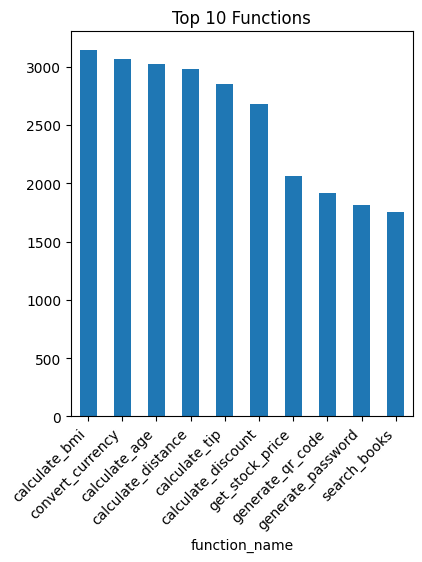

In [105]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
function_dist.head(10).plot(kind='bar')
plt.title('Top 10 Functions')
plt.xticks(rotation=45, ha='right')

Text(0.5, 0, 'Number of Messages')

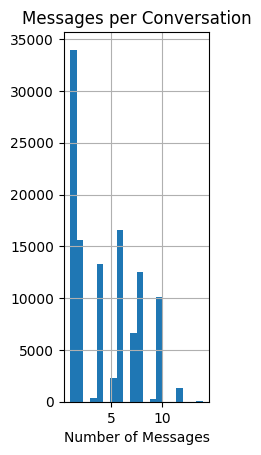

In [106]:
plt.subplot(1, 3, 2)
df['num_messages'].hist(bins=20)
plt.title('Messages per Conversation')
plt.xlabel('Number of Messages')

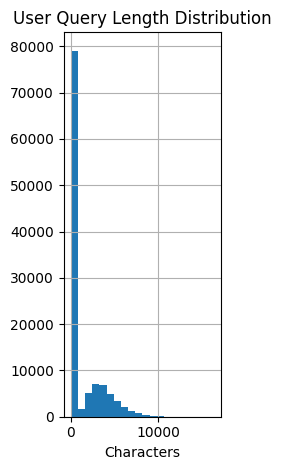

In [107]:
plt.subplot(1, 3, 3)
df['user_query_length'].hist(bins=20)
plt.title('User Query Length Distribution')
plt.xlabel('Characters')

plt.tight_layout()
plt.show()


In [108]:
def analyze_function_arguments(function_calls):
    if not function_calls:
        return {}
    
    all_args = []
    for call in function_calls:
        if call and 'arguments' in call:
            all_args.append(call['arguments'])
    
    return all_args

In [109]:
df['function_arguments'] = df['function_calls'].apply(analyze_function_arguments)

In [111]:
def check_function_success(messages):
    """Check if function calls were successful"""
    has_error = any('error' in str(msg.get('content', '')).lower() 
                   for msg in messages if msg['role'] == 'function')
    return not has_error

df['function_success'] = df['messages'].apply(check_function_success)
print(f"\nFunction Call Success Rate: {df['function_success'].mean()*100:.1f}%")



Function Call Success Rate: 100.0%


In [112]:
def analyze_conversation_flow(messages):
    flow = []
    for msg in messages:
        if msg['role'] == 'assistant' and msg.get('function_call'):
            flow.append('FUNCTION_CALL')
        else:
            flow.append(msg['role'].upper())
    return '->'.join(flow)

In [113]:
df['conversation_flow'] = df['messages'].apply(analyze_conversation_flow)
print("\nMost Common Conversation Flows:")
print(df['conversation_flow'].value_counts().head())


Most Common Conversation Flows:
conversation_flow
USER                                                                                           33976
USER->ASSISTANT                                                                                15590
USER->ASSISTANT->FUNCTION->ASSISTANT                                                           12321
USER->ASSISTANT->USER->ASSISTANT->FUNCTION->ASSISTANT                                          12224
USER->ASSISTANT->FUNCTION->ASSISTANT->USER->ASSISTANT->FUNCTION->ASSISTANT->USER->ASSISTANT     9359
Name: count, dtype: int64


### Glaive-Function-calling-v1

- Apache 2.0
- 52k rows
- https://huggingface.co/datasets/glaiveai/glaive-function-calling

In [3]:
d = load_dataset("glaiveai/glaive-function-calling")

In [4]:
d['train'][12312]

{'sample': 'SYSTEM: You are an helpful assistant who has access to the following functions to help the user, you can use the functions if needed-\n{\n    "name": "calculate_age",\n    "description": "Calculate the age based on the birthdate",\n    "parameters": {\n        "type": "string",\n        "description": "The birthdate in YYYY-MM-DD format",\n        "required": true\n    }\n}\nUSER: Can you help me calculate my age?\nASSISTANT: Sure! I can help you with that. Please provide me with your birthdate in YYYY-MM-DD format.\nUSER: My birthdate is 1990-05-15.\nASSISTANT: <functioncall> {"name": "calculate_age", "arguments": \'{"birthdate": "1990-05-15"}\'}\nFUNCTION RESPONSE: {"age": 31}\nASSISTANT: Based on the provided birthdate, your age is 31.\nUSER: Thank you for calculating my age!\nASSISTANT: You\'re welcome! If you have any more questions or need further assistance, feel free to ask.'}

### Salesforce-xlam-functioncalling-60k

- CC-by-4
- 60k rows
- https://huggingface.co/datasets/Salesforce/xlam-function-calling-60k

In [124]:
d = load_dataset("Salesforce/xlam-function-calling-60k")

In [125]:
d['train'][555]

{'id': 555,
 'query': 'Determine the area of a triangle with a base of 7.5 cm and a height of 3.2 cm.',
 'answers': '[{"name": "triangle_area", "arguments": {"base": 7.5, "height": 3.2}}]',
 'tools': '[{"name": "triangle_area", "description": "Computes the area of a triangle given its base and height.", "parameters": {"base": {"description": "The length of the base of the triangle.", "type": "float"}, "height": {"description": "The height of the triangle.", "type": "float"}}}, {"name": "batting_average", "description": "Calculates the batting average of a baseball player based on the number of hits and at-bats.", "parameters": {"num_hits": {"description": "The number of hits.", "type": "int", "default": 3}, "num_at_bats": {"description": "The number of at-bats.", "type": "int", "default": 3}, "precision": {"description": "The number of decimal places to round the batting average. Defaults to 3.", "type": "int, optional"}}}, {"name": "fibonacci_numbers", "description": "Generates the fi

In [127]:
def parse_json_field(json_str):
    try:
        return json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return []

In [128]:
def extract_parameter_info(tool):
    params = tool.get('parameters', {})
    param_info = {}
    
    for param_name, param_data in params.items():
        param_info[param_name] = {
            'type': param_data.get('type', 'unknown'),
            'has_default': 'default' in param_data,
            'default_value': param_data.get('default'),
            'description': param_data.get('description', '')
        }
    
    return param_info

In [129]:
records = []
for item in tqdm(d['train']):
    tools = parse_json_field(item['tools'])
    answers = parse_json_field(item['answers'])
    
    tool_info = {tool['name']: tool for tool in tools}
    
    used_tools = []
    used_args = []
    for answer in answers:
        if isinstance(answer, dict):
            tool_name = answer.get('name')
            if tool_name:
                used_tools.append(tool_name)
                used_args.append(answer.get('arguments', {}))
    
    record = {
        'id': item['id'],
        'query': item['query'],
        'query_length': len(item['query']),
        'available_tools': list(tool_info.keys()),
        'num_available_tools': len(tools),
        'used_tools': used_tools,
        'num_tools_used': len(used_tools),
        'tool_arguments': used_args,
        'has_numbers': bool(re.search(r'\d+(?:\.\d+)?', item['query'])),
        'is_question': item['query'].strip().endswith('?')
    }
    
    if used_tools:
        main_tool = used_tools[0]
        if main_tool in tool_info:
            tool_def = tool_info[main_tool]
            record.update({
                'main_tool': main_tool,
                'tool_description': tool_def.get('description', ''),
                'parameter_info': extract_parameter_info(tool_def)
            })
    
    records.append(record)

df = pd.DataFrame(records)

100%|████████████████████████████████████████████████████| 60000/60000 [00:06<00:00, 9669.40it/s]


In [131]:
print("\nDataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Unique tools available: {len(set(tool for tools in df['available_tools'] for tool in tools))}")
print(f"Average query length: {df['query_length'].mean():.2f} characters")
print(f"Questions in dataset: {df['is_question'].mean()*100:.1f}%")
print(f"Queries with numbers: {df['has_numbers'].mean()*100:.1f}%")


Dataset Overview:
Total samples: 60000
Unique tools available: 3605
Average query length: 111.89 characters
Questions in dataset: 36.6%
Queries with numbers: 73.3%


In [132]:
all_tools = [tool for tools in df['used_tools'] for tool in tools]
tool_usage = Counter(all_tools)

print("\nTop 10 Most Used Tools:")
for tool, count in tool_usage.most_common(10):
    print(f"{tool}: {count}")


Top 10 Most Used Tools:
search: 1469
loginuser: 458
calculate_standard_deviation: 408
calculate_investment_return: 383
is_perfect_square: 369
is_sum_of_cubes: 366
is_power_of_two: 362
find_n_largest_numbers: 354
sort_numbers: 352
get_ip_zipcode: 352


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'live_giveaways_by_type'),
  Text(1, 0, 'web_chain_details'),
  Text(2, 0, 't3ma'),
  Text(3, 0, 'list_titles'),
  Text(4, 0, 'stagecompetitorstandings'),
  Text(5, 0, 'product_id'),
  Text(6, 0, 'get_id'),
  Text(7, 0, 'search_torrents'),
  Text(8, 0, 'time_zone_api'),
  Text(9, 0, 'find_peak_element')])

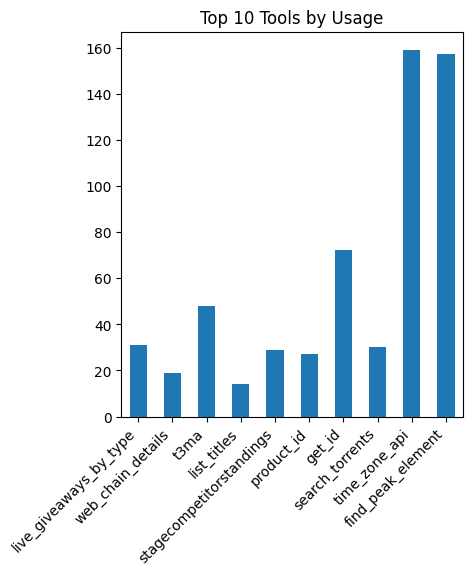

In [133]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
pd.Series(tool_usage).head(10).plot(kind='bar')
plt.title('Top 10 Tools by Usage')
plt.xticks(rotation=45, ha='right')

Text(0.5, 0, 'Characters')

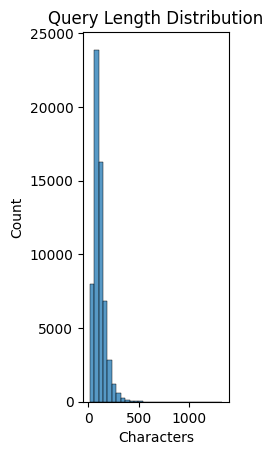

In [134]:
plt.subplot(1, 3, 2)
sns.histplot(data=df, x='query_length', bins=30)
plt.title('Query Length Distribution')
plt.xlabel('Characters')

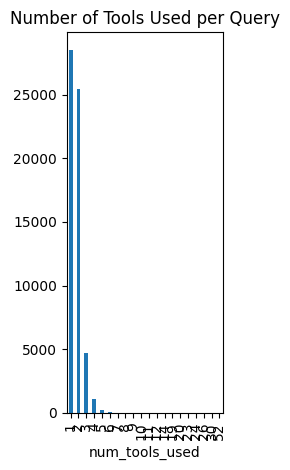

In [139]:
plt.subplot(1, 3, 3)
df['num_tools_used'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Tools Used per Query')
plt.tight_layout()
plt.show()

In [140]:
def analyze_query_patterns(query):
    return {
        'has_numbers': bool(re.search(r'\d+', query)),
        'is_question': query.strip().endswith('?'),
        'starts_with_wh': bool(re.search(r'^(what|where|when|why|who|how)', query.lower())),
        'has_comparison': bool(re.search(r'(compare|versus|vs|difference|between)', query.lower())),
        'has_specific_value': bool(re.search(r'\d+\s*[a-zA-Z]+', query)),  # e.g., "5 meters"
        'has_quotes': bool(re.search(r'"[^"]*"', query))
    }

df['query_patterns'] = df['query'].apply(analyze_query_patterns)
pattern_df = pd.DataFrame(df['query_patterns'].tolist())

In [141]:
print("\nQuery Pattern Analysis:")
for column in pattern_df.columns:
    print(f"{column}: {pattern_df[column].mean()*100:.1f}%")def analyze_tool_parameters():
    param_types = defaultdict(list)
    param_defaults = defaultdict(list)
    
    for _, row in df.iterrows():
        if isinstance(row.get('parameter_info'), dict):
            for param_name, param_data in row['parameter_info'].items():
                param_types[param_name].append(param_data['type'])
                if param_data['has_default']:
                    param_defaults[param_name].append(param_data['default_value'])
    
    return {
        'types': {k: Counter(v).most_common() for k, v in param_types.items()},
        'defaults': param_defaults
    }


Query Pattern Analysis:
has_numbers: 73.3%
is_question: 36.6%
starts_with_wh: 18.6%
has_comparison: 3.4%
has_specific_value: 45.6%
has_quotes: 0.0%


In [142]:
def analyze_tool_parameters():
    param_types = defaultdict(list)
    param_defaults = defaultdict(list)
    
    for _, row in df.iterrows():
        if isinstance(row.get('parameter_info'), dict):
            for param_name, param_data in row['parameter_info'].items():
                param_types[param_name].append(param_data['type'])
                if param_data['has_default']:
                    param_defaults[param_name].append(param_data['default_value'])
    
    return {
        'types': {k: Counter(v).most_common() for k, v in param_types.items()},
        'defaults': param_defaults
    }

In [143]:
param_analysis = analyze_tool_parameters()
print("\nParameter Analysis:")
print("\nParameter Types:")
for param, types in param_analysis['types'].items():
    print(f"{param}: {types[0][0] if types else 'unknown'}")


Parameter Analysis:

Parameter Types:
type: str
chain_slug: str
symbol: str
interval: str
format: str, optional
v_factor: int, optional
series_type: str, optional
outputsize: int, optional
time_period: int, optional
genres: str, optional
limit: int, optional
source_ids: str
source_types: str
types: str
regions: str
sort_by: str, optional
page: int, optional
network_ids: str
release_date_start: int
release_date_end: int
is_id: str
locale: str, optional
currency: str, optional
country: str, optional
q: str
nums: List[int]
url: str
timestamp: int
callback: str, optional
domain: str
query: str
day: int
year: int
month: int
location: str
items: list
quantity: list
aweme_id: int
locale_info: str
lang_id: int, optional
time_utc_offset: int, optional
present_value: float
annual_interest_rate: float
years: int
latitude: int
longitude: int
from_date: str
to_date: str
elevation: int, optional
time: float
a: float
b: int
experiment_id: int
identifier: str
choice: str
count: int, optional
currentc

In [144]:
def analyze_tool_arguments():
    arg_patterns = defaultdict(int)
    for args_list in df['tool_arguments']:
        for args in args_list:
            for arg_name, arg_value in args.items():
                if isinstance(arg_value, (int, float)):
                    arg_patterns[f"{arg_name}_numeric"] += 1
                elif isinstance(arg_value, bool):
                    arg_patterns[f"{arg_name}_boolean"] += 1
                elif isinstance(arg_value, str):
                    arg_patterns[f"{arg_name}_string"] += 1
    return arg_patterns

arg_analysis = analyze_tool_arguments()
print("\nArgument Type Patterns:")
for pattern, count in sorted(arg_analysis.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{pattern}: {count}")


Argument Type Patterns:
is_id_string: 5686
symbol_string: 3233
is_id_numeric: 3034
page_numeric: 2494
q_string: 2383
num_numeric: 2285
limit_numeric: 2186
date_string: 2074
country_string: 2026
text_string: 1889


In [145]:
print("\nSample Queries:")
for tool_name, _ in tool_usage.most_common(3):
    sample = df[df['used_tools'].apply(lambda x: tool_name in x)].iloc[0]
    print(f"\nTool: {tool_name}")
    print(f"Query: {sample['query']}")
    print(f"Arguments: {sample['tool_arguments'][0] if sample['tool_arguments'] else 'None'}")


Sample Queries:

Tool: search
Query: Find articles from the last week about COVID-19 in the UK. Also, suggest keywords for 'healthcare technology'.
Arguments: {'q': 'COVID-19', 'gl': 'UK', 'tbs': 'qdr:w'}

Tool: loginuser
Query: Attempt login with 'frank' and 'frankpass'. Retrieve reviews for the product with 'goods_id' as '10196865'.
Arguments: {'username': 'frank', 'password': 'frankpass'}

Tool: calculate_standard_deviation
Query: Find the standard deviation of the scores of a test: 80, 85, 90, 82, 88.
Arguments: {'numbers': [80, 85, 90, 82, 88]}


### Argilla-Tool-Calling

- Apache 2.0
- 60k examples
- https://huggingface.co/datasets/argilla-warehouse/apigen-synth-trl

In [33]:
d = load_dataset("argilla-warehouse/apigen-synth-trl")

In [34]:
d['train'][43123]

{'messages': [{'content': 'You are an expert in composing functions. You are given a question and a set of possible functions. \nBased on the question, you will need to make one or more function/tool calls to achieve the purpose. \nIf none of the functions can be used, point it out and refuse to answer. \nIf the given question lacks the parameters required by the function, also point it out.\n\nThe output MUST strictly adhere to the following format, and NO other text MUST be included.\nThe example format is as follows. Please make sure the parameter type is correct. If no function call is needed, please make the tool calls an empty list \'[]\'.\n```\n<tool_call>[\n{"name": "func_name1", "arguments": {"argument1": "value1", "argument2": "value2"}},\n... (more tool calls as required)\n]</tool_call>\n```',
   'role': 'system'},
  {'content': 'You have access to the following tools:\n<tools>[{"type":"function","function":{"name":"remove_dir_recursively","description":"Recursively removes 

In [1]:
import transformers
import torch

model_id = "meta-llama/Llama-3.3-70B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cu",
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Device set to use cuda:0


In [13]:
EXAMPLE = d['train'][123]

In [14]:
EXAMPLE

{'id': 123,
 'query': 'Can you fetch the latest betting tips sorted by descending ID and also provide the schedule for the Los Angeles Lakers in the 2023 season?',
 'answers': '[{"name": "get_all_predictions", "arguments": {"sort": "-id"}}, {"name": "get_team_schedule", "arguments": {"season": "2023", "teamabv": "LAL"}}]',
 'tools': '[{"name": "get_all_predictions", "description": "Fetches all betting tips from the API with configurable parameters for connection, content type, sorting, and API key.", "parameters": {"connection": {"description": "Specifies the connection type for the API request. Default is \'keep-alive\'.", "type": "str", "default": "keep-alive"}, "content_type": {"description": "Sets the content type for the API request. Default is \'application/json\'.", "type": "str", "default": "application/json"}, "sort": {"description": "Criterion for sorting the betting tips. Default is \'-id\' for descending order.", "type": "str", "default": "-id"}}}, {"name": "get_team_schedu

In [16]:
SYSTEM_PROMPT = """
You are high 170IQ reasoning scientist model, your job is to take existing messages from conversations with a dumb AI and 
add reasoning to it, remember we are adding chain of thought to the existing example without modifying what it does, 
think out loud and max out your tokens. 

Below is an example: 

INPUT: "{'id': 12314,
 'query': 'Can you provide the innings details for the cricket event with ID 12345 and the football predictions for the Premier League on August 15, 2023?',
 'answers': '[{"name": "innings_cricket", "arguments": {"event_id": 12345}}, {"name": "daily_predictions", "arguments": {"league": "Premier League", "date": "2023-08-15"}}]',
 'tools': '[{"name": "innings_cricket", "description": "Fetch innings data for a cricket event given the event ID.", "parameters": {"event_id": {"description": "The unique identifier of the cricket event.", "type": "int", "default": "10188874"}}}, {"name": "daily_predictions", "description": "Fetches daily football predictions using various filters and pagination support.", "parameters": {"league": {"description": "The league identifier for filtering predictions. Example: \'1\'.", "type": "str, optional", "default": ""}, "page": {"description": "The page number for pagination. Example: \'1\'.", "type": "str, optional", "default": "1"}, "market": {"description": "The market type for filtering predictions. Example: \'1X2\', \'OU25\', \'bts\'.", "type": "str, optional", "default": ""}, "date": {"description": "The date for filtering predictions in the format \'YYYY-MM-DD\'. Example: \'2022-08-13\'.", "type": "str, optional", "default": ""}}}]'}"

OUTPUT: "{'id': 12314,
 'query': 'Can you provide the innings details for the cricket event with ID 12345 and the football predictions for the Premier League on August 15, 2023?',
 'reasoning' : 'To address the query regarding the innings details for a specific cricket event and the football predictions for the Premier League on a given date, we must break down the problem into its components and apply logical reasoning to each part. The query involves two distinct tasks:\n\n1. **Fetching Innings Details for a Cricket Event**: This task requires accessing data related to a cricket event specified by an ID (in this case, 12345). The tool designed for this purpose is `innings_cricket`, which takes an `event_id` as its argument. By providing the `event_id` as 12345 to the `innings_cricket` tool, we can obtain the innings details for the specified cricket event.\n\n2. **Fetching Football Predictions for the Premier League**: The second task involves obtaining football predictions for the Premier League on a specific date, August 15, 2023. The tool suited for this task is `daily_predictions`, which can filter predictions based on several parameters, including `league`, `date`, and others. To get the desired predictions, we need to set the `league` parameter to "Premier League" and the `date` parameter to "2023-08-15" when using the `daily_predictions` tool.\n\nGiven the structure of the query and the tools available, the logical approach to solving this problem involves:\n\n- **Identifying the Tools Needed**: Recognize that two separate tools (`innings_cricket` and `daily_predictions`) are required to fulfill the different parts of the query.\n- **Applying Parameters**: Understand the parameters each tool requires. For `innings_cricket`, the critical parameter is `event_id`. For `daily_predictions`, the key parameters are `league` and `date`.\n- **Executing the Tools**: With the parameters identified, execute each tool with its respective parameters. For `innings_cricket`, execute with `event_id = 12345`. For `daily_predictions`, execute with `league = "Premier League"` and `date = "2023-08-15"`.\n- **Combining the Results**: Finally, combine the results from both tools to provide a comprehensive answer to the query, ensuring that both the innings details for the cricket event and the football predictions for the Premier League on the specified date are included.\n\nThis step-by-step logical reasoning process ensures that the query is addressed in its entirety, leveraging the capabilities of the provided tools to fetch and combine the required information.'
 'answers': '[{"name": "innings_cricket", "arguments": {"event_id": 12345}}, {"name": "daily_predictions", "arguments": {"league": "Premier League", "date": "2023-08-15"}}]',
 'tools': '[{"name": "innings_cricket", "description": "Fetch innings data for a cricket event given the event ID.", "parameters": {"event_id": {"description": "The unique identifier of the cricket event.", "type": "int", "default": "10188874"}}}, {"name": "daily_predictions", "description": "Fetches daily football predictions using various filters and pagination support.", "parameters": {"league": {"description": "The league identifier for filtering predictions. Example: \'1\'.", "type": "str, optional", "default": ""}, "page": {"description": "The page number for pagination. Example: \'1\'.", "type": "str, optional", "default": "1"}, "market": {"description": "The market type for filtering predictions. Example: \'1X2\', \'OU25\', \'bts\'.", "type": "str, optional", "default": ""}, "date": {"description": "The date for filtering predictions in the format \'YYYY-MM-DD\'. Example: \'2022-08-13\'.", "type": "str, optional", "default": ""}}}]'}"


Make sure you follow this approach and return outputs that add the 'reasoning' traces but DO NOT alter any existing calls
"""

In [20]:
messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": f"{EXAMPLE}"},
]

outputs = pipeline(
    messages,
    max_new_tokens=8126,
)
print(outputs[0]["generated_text"][-1])

KeyError: 'assistant'

In [25]:
print(outputs[0]["generated_text"][-1]['content'])

{'id': 123, 
 'query': 'Can you fetch the latest betting tips sorted by descending ID and also provide the schedule for the Los Angeles Lakers in the 2023 season?', 
'reasoning': 'To address this query, we must break it down into its components and apply logical reasoning to each part. The query involves two distinct tasks:

1. **Fetching the Latest Betting Tips Sorted by Descending ID**: This task requires accessing betting tips data and sorting it in descending order based on the ID. The tool designed for this purpose is `get_all_predictions`, which allows for configurable sorting. By setting the `sort` parameter to `-id`, we can obtain the betting tips sorted as required.

2. **Fetching the Schedule for the Los Angeles Lakers in the 2023 Season**: The second task involves obtaining the schedule for a specific NBA team, the Los Angeles Lakers, for the 2023 season. The tool suited for this task is `get_team_schedule`, which can fetch the schedule based on the season and team. To get t